In [3]:
fpath = "/home/stc/devspace/codes/SpinEchoSim/"

# CPU
include(join([fpath,"SpinEchoSim_cpu.jl"]))

# GPU
#using CUDA
#include(join([fpath,"SpinEchoSim_gpu.jl"]))

In [254]:
### setup the job

# make the parameter file
params = make_params()

# Jobs: Gaussian, Power, RKKY, AFM Power, P_power, d_power

# interaction
# for anistropy test
#params["α"] =   [0.0, 0.1, 0.1] #LinRange(0, 0.1, 5)#LinRange(0.001, 0.005, 3)#[0.000,0.005,0.01];#3*0.015;
#params["α_z"] = [0.5, 0.5, 0.0]#0.5 .- (5*params["α"]);

# varying inplane only
#params["α"] = [0.0, 0.1];
#params["α_z"] = 0;
α_l = [0.10]#[0.04, 0.08, 0.12]

n_α = 1*length(α_l)
α_mat = Array{Any}(undef,n_α)

idx = 1
for ashape in 1#:3
    for α in α_l
        if (ashape == 1)
        α_h = α .*  [1  0  0
                      0 1 0
                      0  0  1]
        elseif (ashape == 2)
        α_h = α .*  [ 1  0  0
                      0  1  0
                      0  0  0]            
        elseif (ashape == 3)
        α_h = α .*  [ 1   0   0
                      0   0   0
                      0   0  -1]              
        end
        α_mat[idx] = α_h
        idx = idx+1
    end
end

params["α_mat"] = α_mat[1];


In [255]:
# number of frequencies
params["n"] = (30, 30) # use 40 for paper figure!

τ_range = range(0.5, 1.5, length=51)
println(collect(τ_range))
params["τ"] = τ_range*convert.(Float32,100e-6)
params["dt"] = convert.(Float32, 0.5)
#params["line_width"] = 0.01
#params["bw"] = 0.1

# make a lattice, pbc = periodic bc or not
params["hlk"] = [1; 1]
params["θ"] = [π/2]
params["r"], params["spin_idx"] = make_lattice(params["hlk"], params["θ"], params["n"])

# make the stencil
params["ξ"] = 8
params["decay_power"] = 3

#params["func_type"] = [0,1,2,1,1,1] # 0: gauss, 1: power, 2: RKKY
#params["afm"] = [false, false, false, true, false, false];
#params["s_w"] = [1.0, 1.0, 1.0, 1.0, 0.0, 0.0];
#params["p_w"] = [0.0, 0.0, 0.0, 0.0, 1.0, 0.0];
#params["d_w"] = [0.0, 0.0, 0.0, 0.0, 0.0, 1.0];

params["func_type"] = 3 # 0: gauss, 1: power, 2: RKKY, 3: uniform
params["afm"] = false;
params["s_w"] = 1.0
params["p_w"] = 0.0
params["d_w"] = 0.0

func_type = 3;    
params["M_stencil"] = make_stencil(params["r"], params["ξ"], params["decay_power"],func_type)
# dissipation parameters
params["Γ"] = (0, 0, 10^-7);

# load the pulsing parameters
params["flip_angle"] = [20/90, 60/90, 90/90] .* π/2#LinRange(10/90,170/90,17) .* π/2;
params["phases"] = (0, π/2)

# cpmg parameters
params["echo_time"] = 100e-6 # collect(LinRange(50e-6, 300e-6, 20));
params["num_echoes"] = convert.(Int64, round.(1000e-6./params["echo_time"]));

# set the variables
#vars = ["α_mat"]
#vars = ["flip_angle"]
#vars = ["α_mat","flip_angle"]
vars = ["flip_angle","τ"]

params["vars"] = vars;

# generate indexing (needed for temp_params function)
I, d = make_idx(vars, params);

for th in params["flip_angle"]
    print(string(round(180/π * th)," "))
end
print("\n")


[0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.62, 0.64, 0.66, 0.68, 0.7, 0.72, 0.74, 0.76, 0.78, 0.8, 0.82, 0.84, 0.86, 0.88, 0.9, 0.92, 0.94, 0.96, 0.98, 1.0, 1.02, 1.04, 1.06, 1.08, 1.1, 1.12, 1.14, 1.16, 1.18, 1.2, 1.22, 1.24, 1.26, 1.28, 1.3, 1.32, 1.34, 1.36, 1.38, 1.4, 1.42, 1.44, 1.46, 1.48, 1.5]
20.0 60.0 90.0 


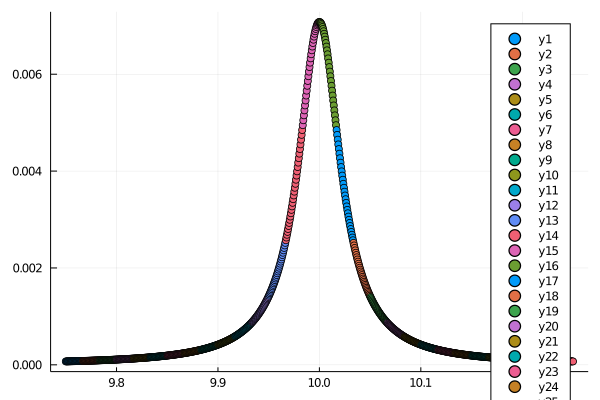

In [256]:
using Plots

tparams = make_temp_params(params, vars, I[1]);
scatter(tparams["ν"],tparams["P"])
#histogram( broadcast(real,tparams["ν"][:]),bins=300)

In [ ]:
# simulate
M = Array{Any}(undef,size(I))
Mv = Array{Any}(undef,size(I))

for idx in I
    # generate temporary parameters
    tparams = make_temp_params(params, vars, idx);
    #tparams["M_stencil"] = make_stencil(tparams["r"], tparams["ξ"], tparams["decay_power"],tparams["func_type"],tparams["afm"],tparams["s_w"],tparams["p_w"],tparams["d_w"])
    #tparams["ν"] = tparams["ν"] .+ 0.1
    @time M[idx], Mv[idx] = spin_echo_sim_liouville(tparams);        
    #@time M[idx] = spin_echo_sim(tparams);        

end
println("done!")

 31.038221 seconds (26.00 M allocations: 106.656 GiB, 6.59% gc time)
 31.025172 seconds (26.00 M allocations: 106.656 GiB, 6.52% gc time)
 31.003439 seconds (26.00 M allocations: 106.656 GiB, 6.50% gc time)
 32.198776 seconds (27.04 M allocations: 110.896 GiB, 6.48% gc time)
 32.229548 seconds (27.04 M allocations: 110.896 GiB, 6.51% gc time)
 32.137451 seconds (27.04 M allocations: 110.896 GiB, 6.48% gc time)
 33.465790 seconds (28.11 M allocations: 115.305 GiB, 6.47% gc time)
 34.228894 seconds (28.11 M allocations: 115.305 GiB, 7.71% gc time)
 33.924367 seconds (28.11 M allocations: 115.305 GiB, 6.78% gc time)
 35.963729 seconds (29.14 M allocations: 119.545 GiB, 6.75% gc time)
 35.143274 seconds (29.14 M allocations: 119.545 GiB, 6.77% gc time)
 35.166677 seconds (29.14 M allocations: 119.545 GiB, 6.73% gc time)
 36.283060 seconds (30.17 M allocations: 123.785 GiB, 6.73% gc time)
 36.290704 seconds (30.17 M allocations: 123.785 GiB, 6.72% gc time)
 36.246836 seconds (30.17 M alloca

In [242]:
using Plots
p = Vector{Any}(undef,size(M)[1])
#p = Vector{Any}(undef,1)
dh = 0*0.2;

for alpha_idx in 1:size(M)[1]
    p[alpha_idx] = plot()
    for run_idx in 1:size(M)[2]
        t_max = 3.0*params["τ"][run_idx]*1e6
        echo_t = t_max*2/3;

        t = LinRange(0, t_max, size(M[alpha_idx,run_idx], 1));
        alpha_str = string(α_l[alpha_idx])
        
        d1 = (alpha_idx-1) % 3 + 1;
        d2 = convert(Int64,ceil(alpha_idx/3))
        dim_str = string(d1,d2)
                
        #t_s = 1.3*t_max*(d2-1);
        #M_s = dh*(3-d1);
 
        t_s = 0*-echo_t;
        M_s = dh*(run_idx-1)
        
        p[alpha_idx] = plot!(t .+ t_s,broadcast(real,M[alpha_idx,run_idx]) .+ M_s,linecolor=:red)
        p[alpha_idx] = plot!(t .+ t_s,broadcast(imag,M[alpha_idx,run_idx]) .+ M_s,linecolor=:blue)
        p[alpha_idx] = plot!([0,t_max] .+ t_s, M_s .+ [0,0], linecolor=:black, linestyle=:dash,legend=:false)
        p[alpha_idx] = plot!(xlim=[0,450])
        if (run_idx == 1)
            #p[alpha_idx] = plot!([0,0],[-0.5,0.1],linecolor=:grey)  
            annotate!(p[alpha_idx],100, 0.15, alpha_str);
        end
    end
end

#plot(p[1],p[2],p[3],legend=false,size=(400,500))
#plot(p[2],p[4],p[7],p[10],p[13],p[16],p[18],layout=(1,7),legend=false,size=(1200,300))
#plot(p[1+ps],p[2+ps],p[3+ps],p[4+ps],p[5+ps],p[6+ps],layout=(1,6),legend=false,size=(600,1000))
plot(p[1],p[2],p[3],layout=(1,3),size=(1200,500))
#savefig("tau_and_alpha_sweep_uncentered-10-27-2021.pdf")

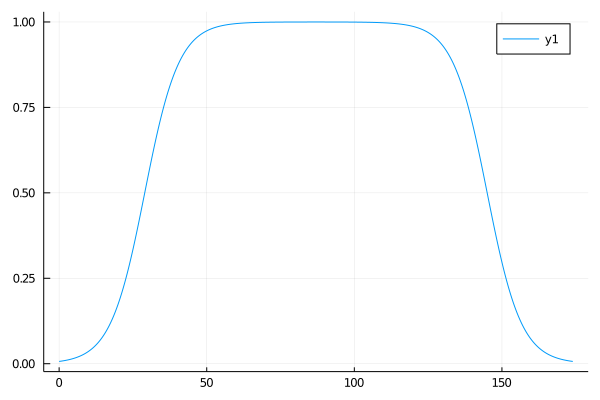

In [218]:
using FFTW

#p = Vector{Any}(undef,size(M)[2])
p = Vector{Any}(undef,1)

dh = 0.5;
ν0 = 10;

run_idx = 5;
alpha_idx = 1;
τ = params["τ"][run_idx]*1e6;
t_max = 3.0*τ
echo_t = τ*2/3;

# select a truncated window to FFT
dt_start = 0
dt_end = dt_start
M0 = convert(Array{Complex{Float64}},M[alpha_idx,run_idx])
nt = size(M0, 1)
M0_trunc = M0[convert(Int64,round(nt/3 + dt_start)):convert(Int64,round(nt - dt_end))]
ntrunc = size(M0_trunc,1)
t = LinRange(0, t_max, size(M0_trunc, 1))
dt = t[2]-t[1]
t_envelope = 1 ./(1 .+ exp.(-10/τ .* (t .- 0.5*τ)))
t_envelope = t_envelope .* reverse(t_envelope)
zn = 8;
zero_pad = zeros(Complex{Float64},2*2^zn + ntrunc)
# figure out the "frequency axis" after the FFT
Fs = 1/dt;
N = size(zero_pad,1)
freq_ax = (((0:N-1) .+ 1/2)/N .- 1/2)*Fs;
plot(t,t_envelope)

In [249]:
# pulse sweep
for alpha_idx in 1:size(M)[1]
    p[alpha_idx] = plot()
    for run_idx in 1:size(M)[2]
        
        d1 = (alpha_idx-1) % 3 + 1;
        d2 = convert(Int64,ceil(alpha_idx/3))
        dim_str = string(d1,d2)
        alpha_str = string(1000*α_l[alpha_idx], " kHz")

        #f_s = 0.5*(d2-1);
        #M_s = 1.5*(3-d1);
        
        f_s = 0;
        M_s = 1.5*(run_idx-1)
        
        τ = params["τ"][run_idx]*1e6
        t_max = 3.0*τ
        echo_t = τ*2/3;

        # select a truncated window to FFT
        dt_start = 0
        dt_end = dt_start
        M0 = convert(Array{Complex{Float64}},M[alpha_idx,run_idx])
        nt = size(M0, 1)
        M0_trunc = M0[convert(Int64,round(nt/3 + dt_start)):convert(Int64,round(nt - dt_end))]
        ntrunc = size(M0_trunc,1)
        t = LinRange(0, t_max, size(M0_trunc, 1))
        dt = t[2]-t[1]
        t_envelope = 1 ./(1 .+ exp.(-10/τ .* (t .- 0.8*τ)))
        t_envelope = t_envelope .* reverse(t_envelope)
        zn = 2;
        zero_pad = zeros(Complex{Float64},2*2^zn + ntrunc)
        # figure out the "frequency axis" after the FFT
        Fs = 1/dt;
        N = size(zero_pad,1)
        freq_ax = (((0:N-1) .+ 1/2)/N .- 1/2)*Fs;
        
        # load in the M data
        M0 = convert(Array{Complex{Float64}},M[alpha_idx,run_idx])

        # select a truncated window to FFT
        M0_trunc = t_envelope .* M0[convert(Int64,round(nt/3 + dt_start)):convert(Int64,round(nt - dt_end))]
        M0_trunc_z = zero_pad
        M0_trunc_z[(2^zn+1):(2^zn + ntrunc)] = M0_trunc
        
        # FFT!
        M0_fft = fftshift(fft(fftshift(M0_trunc_z)))

        if (maximum(broadcast(abs,M0_fft)) != 0)
           M0_fft = M0_fft/maximum(broadcast(abs,broadcast(abs,M0_fft))) # normalize
        end  
        
        color_here = RGB(1,0,0)
        plot!(p[alpha_idx],freq_ax .+ f_s, 0*broadcast(abs,M0_fft) .+ M_s,color=RGB(0,0,0),linestyle=:dash,label="")
        plot!(p[alpha_idx],freq_ax .+ f_s,   broadcast(abs,M0_fft) .+ M_s,xlim=0 .+ [-0.15,0.15],label="",color=color_here,linewidth=2)
        plot!(p[alpha_idx],[0, 0] .+ f_s, [0, 1] .+ M_s,color=RGB(0,0,0),linestyle=:dash)

        if (run_idx == 1)
            #p[alpha_idx] = plot!([0,0],[-0.5,0.1],linecolor=:grey)  
            annotate!(p[alpha_idx],0, 77, alpha_str);
        end
    
    end
end

#plot(p[1],p[2],p[3],legend=false,size=(400,500))
#plot(p[2],p[4],p[7],p[10],p[13],p[16],p[18],layout=(1,7),legend=false,size=(1200,300))
plot(p[1],p[2],p[3],legend=false,layout=(1,3),size=(600,1000))
#savefig("tau_and_alpha_sweep_fft-10-27-2021.pdf")

(3, 19)
(3, 19)


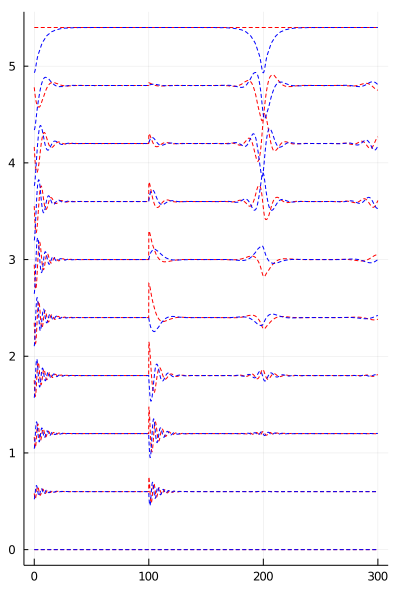

In [8]:

ax_m = 0.2;
tmax = 300;

println(size(M))
println(size(Mv))

plot()
for tar_idx = 1:10

    scale = 1;
    if (tar_idx == 2)
        scale = 1;
    end
    Mh0 = scale*M[1,tar_idx];
    Mx0 = broadcast(real,Mh0);
    My0 = broadcast(imag,Mh0);
    Mz0 = broadcast(real,Mv[1,tar_idx]);
    
    Mh = scale*M[2,tar_idx];
    Mx = broadcast(real,Mh);
    My = broadcast(imag,Mh)
    Mz = broadcast(real,Mv[2,tar_idx]);

    t = LinRange(0,tmax,length(Mh))
    r = broadcast(abs,Mh)
    th = atan.(Mx,My)
    nt = length(Mh)
    tau = convert(Int64,nt/3)
    
    dh = 0.6*(tar_idx-1);

    #plot!(t, Mx .+ dh, color=:red)
    #plot!(t, My .+ dh, color=:blue)
    #plot!(t, Mz .+ dh, color=:black)

    plot!(t, Mx0 .+ dh, color=:red, linestyle=:dash)
    plot!(t, My0 .+ dh, color=:blue, linestyle=:dash)
    #plot!(t, Mz0, color=:black, linestyle=:dash)


end
#plot( Mr, Mi, title=string(round(180/π * params["flip_angle"][tar_idx])))
#scatter!( real(Mh[1:tau]), imag(Mh[1:tau]) )
#scatter!( real(Mh[tau:2*tau]), imag(Mh[tau:2*tau]) )
#scatter!( real(Mh[2*tau:3*tau]), imag(Mh[2*tau:3*tau]),xlim=[-ax_m,ax_m],ylim=[-ax_m,ax_m] )

#plot(th ./ (2 * π))
#plot!(4*r)
plot!(size=(400,600),legend=:none)

In [17]:
using FFTW
using LaTeXStrings

ν0 = params["ν0"]

t_max = 2*params["τ"]*1e6; # 200 micro seconds
f = params["flip_angle"];

alph_list = params["α"]
alph_z_list = params["α_z"]

dt_start = 0;
dt_end = dt_start;

M0 = convert(Array{Complex{Float64}},M[1,1])
nt = size(M0, 1)

# select a truncated window to FFT
M0_trunc = M0[convert(Int64,round(nt/3 + dt_start)):convert(Int64,round(nt - dt_end))]
ntrunc = size(M0_trunc,1)
t = LinRange(0, t_max, size(M0_trunc, 1))
dt = t[2]-t[1]
t_envelope = 1 ./(1 .+ exp.(-0.1 .* (t .- 80)))
t_envelope = t_envelope .* reverse(t_envelope)

alpha_list = params["α"]
alpha_z_list = params["α_z"]

zn = 4;
zero_pad = zeros(Complex{Float64},2*2^zn + ntrunc)

# figure out the "frequency axis" after the FFT
Fs = 1/dt;
N = size(zero_pad,1)
freq_ax = (((0:N-1) .+ 1/2)/N .- 1/2)*Fs;
# pulse sweep

nAlph = size(M)[1];
nFlip = size(M)[2];

plot(t,t_envelope)

p = Vector{Any}(undef,nAlph)

for alpha_idx = 1:nAlph
    p[alpha_idx] = plot();
    for run_idx in 1:nFlip
        # load in the M data
        M0 = convert(Array{Complex{Float64}},M[alpha_idx,run_idx])

        # select a truncated window to FFT
        M0_trunc = t_envelope .* M0[convert(Int64,round(nt/3 + dt_start)):convert(Int64,round(nt - dt_end))]
        M0_trunc_z = zero_pad
        M0_trunc_z[(2^zn+1):(2^zn + ntrunc)] = M0_trunc
        
        ang_here = (f[run_idx]*180/π);
        ang_str = string(round(ang_here),"°");
        power_str = string("[", round(alpha_z_list[alpha_idx],digits=3), ", ", round(alpha_list[alpha_idx],digits=3) , "]");

        # labeling
        alpha_str = latexstring("\\textrm{",round(alpha_list[alpha_idx],digits=4),"}")
        c_x = (run_idx-size(M)[2]/2)/size(M)[2]
        color_here = RGB(0.5+.5*c_x,0.5,0.5-c_x)
        # plot the time-domian results
        M0_trunc_abs = broadcast(abs,M0_trunc) # normalize
        if (maximum(M0_trunc_abs) != 0)
            M0_trunc_abs = M0_trunc_abs/maximum(M0_trunc_abs)
        end
        #plot!(plt3,t, M0_trunc_abs .+ 2*(run_idx-1),label="",color=color_here,linewidth=2, xlim=[t[1],t[length(t)]])
        #plot!(plt3,t, 0*M0_trunc_abs .+ 2*(run_idx-1),color=RGB(0,0,0),linestyle=:dash,label="")

        # FFT!
        M0_fft = fftshift(fft(fftshift(M0_trunc_z)))

        if (maximum(broadcast(abs,M0_fft)) != 0)
           M0_fft = M0_fft/maximum(broadcast(abs,broadcast(abs,M0_fft))) # normalize
        end
        
        if (run_idx == 1 || run_idx == 19)# 180-degree run
            M0_fft = 0.0*M0_fft;
        end
             
        
        plot!(p[alpha_idx],freq_ax .+ ν0, 0*broadcast(imag,M0_fft) .+ 2*(run_idx-1),color=RGB(0,0,0),linestyle=:dash,label="")
        plot!(p[alpha_idx],freq_ax .+ ν0,   broadcast(abs,broadcast(abs,M0_fft)) .+ 2*(run_idx-1),xlim=ν0 .+ [-0.4,0.4],label="",color=color_here,linewidth=2)

        if (run_idx == 1)
            #annotate!(plt2,11.15,0.5+2*(alpha_idx-1),text(alpha_str,color_here, :right,12))
            plot!(p[alpha_idx],ν0 .+ [0,0],[0, 2*nFlip],color=RGB(0,0,0),label="",linestyle=:dot,linewidth=1)
            annotate!(p[alpha_idx],10.0, 40.0,text(power_str,color_here, :center,8))
        end
        if  (mod(run_idx,3) == 1 && alpha_idx == 3)#(run_idx == 1 || run_idx == 4 || run_idx == 7)
            annotate!(p[alpha_idx],10.3, 0.9 + 2*(run_idx-1),text(ang_str,color_here, :right,6))
        end
    end 
    w_ax = [9.75, 10.25];
    plot!(p[alpha_idx],xlim=w_ax,ylim=[0,39],xticks=[9.8,10,10.2])
    xlabel!(p[alpha_idx],"frequency (MHz)")
    #annotate!(p[alpha_idx],10.1,+0.9 + 2*(run_idx-1),text(ang_str,color_here, :left,8))
    
end

cos_func_z = LinRange(0,2*(nFlip-1),100)#2*size(M)[2],100)
cos_func_theta = LinRange(0,pi*1.0,100)

S_func = -0.5/4.0*(cos.(cos_func_theta) + cos.(3 .* cos_func_theta));

xy_func = 0.1/2.0*(sin.(cos_func_theta).^3)
inv_S_func = 0.1/4.0*(cos.(cos_func_theta) + cos.(3*cos_func_theta))


plot!(p[1],yticks=[])
plot!(p[2],yticks=[])
plot!(p[3],yticks=[])

plot!(p[1], 10 .+   S_func, cos_func_z,label="",linestyle=:dash,color=RGB(1,0,0),linewidth=2)
plot!(p[2], 10 .+   S_func .+ inv_S_func, cos_func_z,label="",linestyle=:dash,color=RGB(1,0,1),linewidth=2)
plot!(p[3], 10 .+   inv_S_func, cos_func_z,label="",linestyle=:dash,color=RGB(0,0,1),linewidth=2)


#plot!(p[2], 9.76 .+  2.0*xy_func, cos_func_z,label="",color=RGB(0,0,1))
#plot!(p[2], 9.76 .+  0.0*xy_func, cos_func_z,label="",color=RGB(0,0,1))

#plot!(p[3], 9.76 .+  2.0*xy_func, cos_func_z,label="",color=RGB(0,0,1))
#plot!(p[3], 9.76 .+  0.0*xy_func, cos_func_z,label="",color=RGB(0,0,1))

ylabel!(p[1],"|M|")

fig_x = 1*40*10;
fig_y = 1*35*10;
#plot(p[1],p[2],p[3],p[4],p[5],layout=(1,5),size=(fig_x,fig_y))
plot(p[1],p[2],p[3],layout=(1,3),size=(fig_x,fig_y))
#plot(p[1],p[2],p[3],p[4],p[5],layout=(1,5),size=(fig_x,fig_y))

#plot(p[4],size=(fig_x/3.0,fig_y))

#savefig("alpha_ratio_sweep_abs_10-04-2021.pdf")

In [15]:
using JLD2
#@save "prl_fig2_aniso_sweep_data_10-04-2021.jld2"

In [16]:
@load "prl_fig2_aniso_sweep_data_10-04-2021.jld2"

In [37]:
# for SM comparison (frequency-domain)
using FFTW
using LaTeXStrings

#Mh = M[2,:]; # Mb
Mh = M[3,:]; # Mc
ν0 = 10;

t_max = 2*0.0001*1e6; # 200 micro seconds
f = params["flip_angle"];

#alpha = params[1,1]
#alpha_z = params[1,3]

dt_start = 0;
dt_end = dt_start;

M0 = Mh[1]
nt = size(M0, 1)

# select a truncated window to FFT
M0_trunc = M0[convert(Int64,round(nt/3 + dt_start)):convert(Int64,round(nt - dt_end))]
ntrunc = size(M0_trunc,1)
t = LinRange(0, t_max, size(M0_trunc, 1))
dt = t[2]-t[1]
t_envelope = 1 ./(1 .+ exp.(-0.1 .* (t .- 80)))
t_envelope = t_envelope .* reverse(t_envelope)

zn = 4;
zero_pad = zeros(Complex{Float64},2*2^zn + ntrunc)

# figure out the "frequency axis" after the FFT
Fs = 1/dt;
N = size(zero_pad,1)
freq_ax = (((0:N-1) .+ 1/2)/N .- 1/2)*Fs;
# pulse sweep

#nAlph = size(M)[1];
nFlip = size(Mh)[1];

plot(t,t_envelope)

p = plot();
for run_idx in 1:nFlip
    # load in the M data
    M0 = Mh[run_idx]

    # select a truncated window to FFT
    M0_trunc = t_envelope .* M0[convert(Int64,round(nt/3 + dt_start)):convert(Int64,round(nt - dt_end))]
    M0_trunc_z = zero_pad
    M0_trunc_z[(2^zn+1):(2^zn + ntrunc)] = M0_trunc

    ang_here = convert(Int64,round(f[run_idx]*180/π));
    ang_str = string(ang_here,"°");
    #power_str = string("[", round(alpha_z,digits=3), ", ", round(alpha,digits=3) , "]");

    # labeling
    #alpha_str = latexstring("\\textrm{",round(alpha,digits=4),"}")
    c_x = (run_idx-size(Mh)[1]/2)/size(Mh)[1]
    color_here = RGB(0.5+.5*c_x,0.5,0.5-c_x)
    # plot the time-domian results
    M0_trunc_abs = broadcast(abs,M0_trunc) # normalize
    if (maximum(M0_trunc_abs) != 0)
        M0_trunc_abs = M0_trunc_abs/maximum(M0_trunc_abs)
    end
    #plot!(plt3,t, M0_trunc_abs .+ 2*(run_idx-1),label="",color=color_here,linewidth=2, xlim=[t[1],t[length(t)]])
    #plot!(plt3,t, 0*M0_trunc_abs .+ 2*(run_idx-1),color=RGB(0,0,0),linestyle=:dash,label="")

    # FFT!
    M0_fft = fftshift(fft(fftshift(M0_trunc_z)))

    if (maximum(broadcast(abs,M0_fft)) != 0)
       M0_fft = M0_fft/maximum(broadcast(abs,M0_fft)) # normalize
    end

    if (run_idx == 1 || run_idx == 19)# 180-degree run
        M0_fft = 0.0*M0_fft;
    end


    plot!(p,freq_ax .+ ν0, 0*broadcast(abs,M0_fft) .+ 2*(run_idx-1),color=RGB(0,0,0),linestyle=:dash,label="")
    plot!(p,freq_ax .+ ν0,   broadcast(abs,M0_fft) .+ 2*(run_idx-1),xlim=ν0 .+ [-0.4,0.4],label="",color=color_here,linewidth=2)

    if (run_idx == 1)
        #annotate!(plt2,11.15,0.5+2*(alpha_idx-1),text(alpha_str,color_here, :right,12))
        plot!(p,ν0 .+ [0,0],[0, 2*nFlip],color=RGB(0,0,0),label="",linewidth=2)
        #annotate!(p[alpha_idx],10.0, 40.0,text(power_str,color_here, :center,8))
    end
    if  (mod(run_idx,3) == 1)#(run_idx == 1 || run_idx == 4 || run_idx == 7)
        annotate!(p,10.3, 0.9 + 2*(run_idx-1),text(ang_str,color_here, :right,10))
    end
end 
w_ax = [9.75, 10.25];
plot!(p,xlim=w_ax,ylim=[0,39],xticks=[9.8,10,10.2])
xlabel!(p,"frequency (MHz)")
#annotate!(p[alpha_idx],10.1,+0.9 + 2*(run_idx-1),text(ang_str,color_here, :left,8))


cos_func_z = LinRange(0,2*(nFlip-1),100)#2*size(M)[2],100)
cos_func_theta = LinRange(0,pi*1.0,100)

S_func = -0.0/4.0*(cos.(cos_func_theta) + cos.(3 .* cos_func_theta));

xy_func = 0.1/2.0*(sin.(cos_func_theta).^3)
inv_S_func = 0.1/4.0*(cos.(cos_func_theta) + cos.(3*cos_func_theta))


plot!(p,yticks=[])

plot!(p, 10 .+   S_func .+ inv_S_func, cos_func_z,label="",linestyle=:dash,color=RGB(1,0,1),linewidth=2)


#plot!(p, 9.76 .+  2.0*xy_func, cos_func_z,label="",color=RGB(0,0,1))
#plot!(p, 9.76 .+  0.0*xy_func, cos_func_z,label="",color=RGB(0,0,1))

ylabel!(p,"|M|")

fig_x = 1*25*10;
fig_y = 2*35*10;
#plot(p[1],p[2],p[3],p[4],p[5],layout=(1,5),size=(fig_x,fig_y))
plot(p,size=(fig_x,fig_y))
#plot(p[1],p[2],p[3],p[4],p[5],layout=(1,5),size=(fig_x,fig_y))

#plot(p[4],size=(fig_x/3.0,fig_y))

savefig("SM_infinite_alpha_ratio_sweep_freq_c.pdf")

In [30]:
# for SM comparison (time-domain)

#Mh = M[2,:]; # Mb
Mh = M[3,:]; # Mc


t_max = 3*0.0001*1e6; # 300 micro seconds
f = params["flip_angle"];

#alpha = params[1,1]
#alpha_z = params[1,3]

dt_start = 0;
dt_end = dt_start;

M0 = Mh[1]
nt = size(M0, 1)

# select a truncated window to FFT
t = LinRange(0, t_max, size(M0, 1))
dt = t[2]-t[1]

#nAlph = size(M)[1];
nFlip = size(Mh)[1];

p = plot();
for run_idx in 1:nFlip
    # load in the M data
    M0 = Mh[run_idx]
    
    ang_here = convert(Int64,round(f[run_idx]*180/π));
    ang_str = string(ang_here,"°");
    #power_str = string("[", round(alpha_z,digits=3), ", ", round(alpha,digits=3) , "]");

    # labeling
    #alpha_str = latexstring("\\textrm{",round(alpha,digits=4),"}")
    c_x = (run_idx-size(Mh)[1]/2)/size(Mh)[1]
    color_here = RGB(0.5+.5*c_x,0.5,0.5-c_x)
    # plot the time-domian results
    M0_abs = broadcast(abs,M0) # normalize
    if (maximum(M0_abs) != 0)
        #M0_abs = M0_abs/maximum(M0_abs)
    end
    plot!(p,t, 5*M0_abs .+ 2*(run_idx-1),label="",color=color_here,linewidth=2, xlim=[t[1],t[length(t)]])
    plot!(p,t, 0*M0_abs .+ 2*(run_idx-1),color=RGB(0,0,0),linestyle=:dash,label="")

    if (run_idx == 1)
        #annotate!(plt2,11.15,0.5+2*(alpha_idx-1),text(alpha_str,color_here, :right,12))
        #plot!(p,100 .+ [0,0],[0, 2*nFlip],color=RGB(0,0,0),label="",linestyle=:dot,linewidth=1)
        plot!(p,200 .+ [0,0],[0, 2*nFlip],color=RGB(0,0,0),label="",linewidth=1)

        #annotate!(p[alpha_idx],10.0, 40.0,text(power_str,color_here, :center,8))
    end
    if  (mod(run_idx,3) == 1)#(run_idx == 1 || run_idx == 4 || run_idx == 7)
        annotate!(p,280, 0.6 + 2*(run_idx-1),text(ang_str,color_here, :right,10))
    end
end 
t_ax = [100, 300];
plot!(p,xlim=t_ax,ylim=[0,39],xticks=0:50:300)
xlabel!(p,"time (μs)")
#annotate!(p[alpha_idx],10.1,+0.9 + 2*(run_idx-1),text(ang_str,color_here, :left,8))

plot!(p,yticks=[])

#plot!(p, 10 .+   S_func .+ inv_S_func, cos_func_z,label="",linestyle=:dash,color=RGB(1,0,1),linewidth=2)


#plot!(p, 9.76 .+  2.0*xy_func, cos_func_z,label="",color=RGB(0,0,1))
#plot!(p, 9.76 .+  0.0*xy_func, cos_func_z,label="",color=RGB(0,0,1))

ylabel!(p,"|M|")

fig_x = 1*25*10;
fig_y = 2*35*10;
#plot(p[1],p[2],p[3],p[4],p[5],layout=(1,5),size=(fig_x,fig_y))
plot(p,size=(fig_x,fig_y))
#plot(p[1],p[2],p[3],p[4],p[5],layout=(1,5),size=(fig_x,fig_y))

#plot(p[4],size=(fig_x/3.0,fig_y))

#savefig("SM_infinite_alpha_ratio_sweep_time_c.pdf")